In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.model_selection import KFold, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline

N_FOLDS = 5
MAX_EVALS = 5

In [2]:
# read csv, get testing sample(20000, 4000)
features = pd.read_csv('FE_train_0630.csv')

features = features.sample(n=60000, random_state=42)

features = features.select_dtypes('number')

features['total_price'] = np.log1p(features['total_price'])
labels = np.array(features['total_price']).reshape((-1, ))
features = features.drop(columns=['total_price'])

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 12000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (48000, 414)
Test shape:  (12000, 414)


,III_10,III_100,III_1000,III_10000,III_250,III_50,III_500,III_5000,III_MIN,III_index_1000,...,building_complete_dt_diff_max_gb_parking_way,building_complete_dt_diff_min_gb_parking_way,house_area_diff_mean_gb_parking_way,house_area_diff_median_gb_parking_way,house_area_diff_max_gb_parking_way,house_area_diff_min_gb_parking_way,house_rate_diff_mean_gb_parking_way,house_rate_diff_median_gb_parking_way,house_rate_diff_max_gb_parking_way,house_rate_diff_min_gb_parking_way
51362,0,3,125,1744,33,2,61,332,27.411018,1,...,-8735,11719,-5.454390,-2.004550,-3726.941729,3.674939,0.000000,0.00000,0.000000,0.000000
32480,0,0,147,9005,1,0,10,3988,112.269954,1,...,-3865,13028,0.436405,2.947883,-626.728545,630.015264,-0.367187,0.00000,-129.010684,1263.536166
35041,0,2,108,4390,5,0,23,1956,83.601317,1,...,-7093,13361,5.206376,8.656216,-3716.280964,14.335705,0.000000,0.00000,0.000000,0.000000
14870,0,0,36,2427,0,0,11,1469,337.585719,1,...,-5356,15098,5.206376,8.656216,-3716.280964,14.335705,0.000000,0.00000,0.000000,0.000000
13961,0,1,331,4891,12,0,80,2758,75.013266,1,...,-9618,7275,-6.120935,-3.609457,-633.285884,623.457925,0.379063,0.74625,-128.264434,1264.282416


In [3]:
features.shape

(60000, 414)

In [4]:
# load default lightGBM Regresor model, and covert lgbm dataset
model = lgb.LGBMRegressor(random_state=50)

train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [5]:
# hit score eval function
def hit_score(preds, train_data):
    trues  = train_data.get_label()
    trues = np.expm1(trues)
    preds = np.expm1(preds)
    scores = ((np.absolute(preds - trues) / trues) <= 0.1)
    hit_score = np.sum(scores) / train_data.num_data()
    return 'Hit_score', hit_score, True

In [6]:
# get hyperparameters, and test cv
hyperparameters = model.get_params()

del hyperparameters['n_estimators']

cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'None', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42, feval=hit_score, stratified=False)

best = cv_results['Hit_score-mean'][-1]
best_std = cv_results['Hit_score-stdv'][-1]

print('The maximium Hit Score in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['Hit_score-mean'])))

c:\users\bug87\appdata\local\programs\python\python37\lib\site-packages\lightgbm\basic.py:755: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


The maximium Hit Score in cross validation was 0.52242 with std of 0.00162.
The ideal number of iterations was 3188.


In [7]:
# using previous cv parameters(n_estimators), predict baseline model score
model.n_estimators = len(cv_results['Hit_score-mean'])

model.fit(train_features, train_labels)
pred = model.predict(test_features)

pred_true = np.expm1(pred)
test_labels_true = np.expm1(test_labels)

score = (np.abs(pred_true - test_labels_true)/test_labels_true) <= 0.1
baseline_hit_score = np.sum(score)/len(test_labels)

print('The baseline model scores {:.5f} Hit scores on the test set.'.format(baseline_hit_score))

The baseline model scores 0.54000 Hit scores on the test set.


In [23]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 500, metrics = 'None', seed = 50, feval=hit_score, stratified=False)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['Hit_score-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['Hit_score-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [8]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [9]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

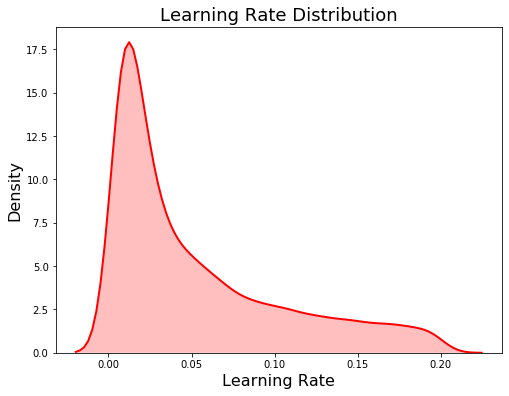

In [10]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

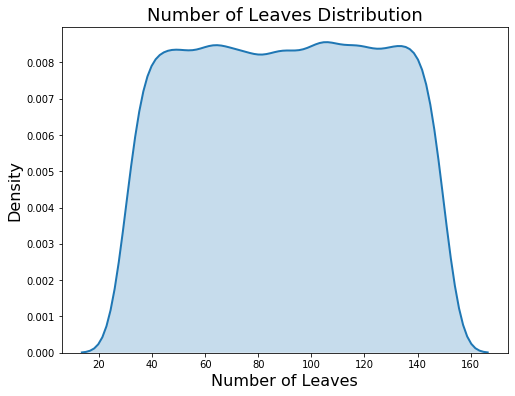

In [11]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

In [12]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'gbdt', 'subsample': 0.8460285239381227}}

In [13]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

hyperparams

{'boosting_type': 'gbdt', 'subsample': 0.8460285239381227}

In [41]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             ]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.03)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
}

In [44]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7523575045796612,
 'is_unbalance': True,
 'learning_rate': 0.012305794013530767,
 'min_child_samples': 300.0,
 'num_leaves': 57.0,
 'reg_alpha': 0.5467176200332752,
 'reg_lambda': 0.8651008239827432,
 'subsample_for_bin': 120000.0,
 'subsample': 0.6940792160949535}

In [16]:
# Create a new file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.60640.
The optimal number of estimators was 786.


In [30]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest

In [31]:
from hyperopt import Trials

# Record results
trials = Trials()

In [32]:
# Create a file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

In [33]:
from hyperopt import fmin

In [34]:
# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

 40%|████      | 2/5 [08:20<13:49, 276.44s/it, best loss: 0.6299]

c:\users\bug87\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """



100%|██████████| 5/5 [21:15<00:00, 258.44s/it, best loss: 0.5869000000000001]


{'boosting_type': 0,
 'colsample_by_tree': 0.7653538787665831,
 'gdbt_subsample': 0.7216069319767673,
 'is_unbalance': 0,
 'learning_rate': 0.037773841063521045,
 'min_child_samples': 65.0,
 'num_leaves': 66.0,
 'reg_alpha': 0.8699268196306537,
 'reg_lambda': 0.6501042191319842,
 'subsample_for_bin': 260000.0}

In [35]:
# Sort the trials with lowest loss (highest AUC) first
trials_dict = sorted(trials.results, key = lambda x: x['loss'])
trials_dict[:1]

[{'loss': 0.5869000000000001,
  'hyperparameters': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.7653538787665831,
   'is_unbalance': True,
   'learning_rate': 0.037773841063521045,
   'min_child_samples': 65,
   'num_leaves': 66,
   'reg_alpha': 0.8699268196306537,
   'reg_lambda': 0.6501042191319842,
   'subsample_for_bin': 260000,
   'subsample': 0.7216069319767673,
   'n_estimators': 2027},
  'iteration': 4,
  'train_time': 702.7345291000001,
  'status': 'ok'}]

In [47]:
results = pd.read_csv(OUT_FILE)

In [39]:
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    
    new_results = results.copy()
    # String to dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMRegressor(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict(test_features)
    
    pred_true = np.expm1(pred)
    test_labels_true = np.expm1(test_labels)

    score = (np.abs(pred_true - test_labels_true)/test_labels_true) <= 0.1
    hit_score = np.sum(score)/len(test_labels)
    
    print('Hit scores from {} on test data = {:.5f}.'.format(name, hit_score))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [48]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results

The highest cross validation score from Bayesian was 0.42180 found on iteration 8.
Hit scores from Bayesian on test data = 0.40083.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,n_estimators,iteration,score
0,gbdt,0.702920,False,0.012493,30,22,0.123362,0.679194,200000,0.701215,6145,8,0.4218
1,gbdt,0.765354,True,0.037774,65,66,0.869927,0.650104,260000,0.721607,2027,4,0.4131
2,gbdt,0.840140,True,0.022948,200,139,0.486344,0.870436,220000,0.784970,2541,9,0.4073
3,gbdt,0.975914,True,0.011772,170,123,0.849147,0.423173,20000,0.543188,2647,10,0.4061
4,gbdt,0.656268,True,0.017225,445,133,0.003443,0.198651,260000,0.512638,4547,7,0.4020
5,gbdt,0.736422,False,0.019644,440,105,0.538427,0.039746,100000,0.710740,3429,6,0.3991
6,gbdt,0.873366,True,0.251159,465,138,0.049846,0.877796,80000,0.844679,2358,1,0.3701
7,gbdt,0.937910,False,0.368475,215,100,0.530276,0.247341,300000,0.838970,531,2,0.3407
8,goss,0.953389,True,0.011789,335,104,0.336801,0.249338,140000,1.000000,84,3,0.1493
9,goss,0.661485,True,0.015543,215,62,0.053910,0.610818,100000,1.000000,64,5,0.1472


In [61]:
bayes_results.head(1).to_dict('records')[0]

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.7029201763584364,
 'is_unbalance': False,
 'learning_rate': 0.012492622789498182,
 'min_child_samples': 30,
 'num_leaves': 22,
 'reg_alpha': 0.12336210430221084,
 'reg_lambda': 0.6791940464273635,
 'subsample_for_bin': 200000,
 'subsample': 0.7012145631421652,
 'n_estimators': 6145,
 'iteration': 8,
 'score': 0.4218}

In [45]:
MAX_EVALS = 10

# Continue training
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

100%|██████████| 5/5 [52:36<00:00, 627.34s/it, best loss: 0.5782]            


In [46]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))

In [ ]:
# MAX_EVALS = 1000

# # Create a new file and open a connection
# OUT_FILE = 'bayesian_trials_1000.csv'
# of_connection = open(OUT_FILE, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
# writer.writerow(headers)
# of_connection.close()

# # Record results
# trials = Trials()

# global ITERATION

# ITERATION = 0 

# best = fmin(fn = objective, space = space, algo = tpe.suggest,
#             trials = trials, max_evals = MAX_EVALS)

# # Sort the trials with lowest loss (highest AUC) first
# trials_dict = sorted(trials.results, key = lambda x: x['loss'])

# print('Finished, best results')
# print(trials_dict[:1])

# # Save the trial results
# with open('trials.json', 'w') as f:
#     f.write(json.dumps(trials_dict))

In [ ]:
def automated_params_tuning(train_dataset, cat_features, max_evals, n_folds):
    # 自動調參 function
    # train_dataset: train dataset(panda.Dataframe)
    # cat_features: categorial features(list)
    # max_evals: evaluation tuning rounds(int)
    # n_folds: num of k-fold cv
    # return: lightgbm parameters(dict)
    return